In [9]:
import pandas as pd
import seaborn as sns
import os
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [35]:
LOGS_FOLDER = "/mnt/c/Users/Diego/Desktop/Logs/Italy_2018_QL_LR_schedule_a05_b2_SC/sim_logs/results"
DATA_FOLDER = "2020-12-23_14-58-27"
directory = os.path.join(LOGS_FOLDER, DATA_FOLDER)
dfs = defaultdict(dict)
for entry in tqdm(os.scandir(directory)):
    if os.path.isfile(entry):
        filename = entry.name
        filename = filename[:-4]
        tokens = filename.split('_')
        timestamp = tokens.pop(0)
        timestamp += tokens.pop(0)
        df = pd.read_csv(entry.path)
        dfs[tokens[0] + "_" + timestamp][tokens[2]] = df
        dfs[tokens[0] + "_" + timestamp]['year'] = tokens[1]

400it [00:01, 231.57it/s]


In [36]:
#database = pd.DataFrame(columns=['race', 'year', 'lap', 'driver', 'lap_time', 'cumulative_time', 'influence', 'position', 'id'])
index = 0
count = 0
rows = []
for i, race_id in enumerate(tqdm(dfs)):
    tokens = race_id.split('_')
    timestamp = tokens[1]
    race = tokens[0]
    year = dfs[race_id]['year']

    lap_times = dfs[race_id]['laptimes']
    influences = dfs[race_id]['lapinfluences']
    positions = dfs[race_id]['positions']
    race_times = dfs[race_id]['racetimes']
    
    columns = list(lap_times.columns)
    columns.remove('lap')

    for lap in lap_times.lap.unique():
        lap_time_single_lap = lap_times.loc[lap_times['lap'] == lap]
        influences_single_lap = influences.loc[influences['lap'] == lap]
        positions_single_lap = positions.loc[positions['lap'] == lap]
        race_times_single_lap = race_times.loc[race_times['lap'] == lap]
        for col in columns:
            index += 1
            new_df = {}
            new_df['id'] = [timestamp]
            new_df['race'] = [race]
            new_df['year'] = [year]
            new_df['lap'] = [lap]
            new_df['driver'] = [col]
            new_df['lap_time'] = lap_time_single_lap[col].values
            new_df['influence'] = influences_single_lap[col].values
            new_df['cumulative_time'] = race_times_single_lap[col].values
            new_df['position'] = positions_single_lap[col].values
            new_df = pd.DataFrame(new_df, index=[index])
            rows.append(new_df)
database = pd.concat(rows)
database.describe()


100%|██████████| 100/100 [01:43<00:00,  1.03s/it]


,lap,lap_time,cumulative_time,position
count,106000.000000,106000.000000,106000.000000,106000.000000
mean,27.000000,88.149478,2393.665691,10.500000
std,15.297131,3.418219,1347.013165,5.766308
min,1.000000,81.962000,89.411000,1.000000
25%,14.000000,86.693000,1239.285000,5.750000
50%,27.000000,87.756000,2398.005500,10.500000
75%,40.000000,88.670000,3563.685500,15.250000
max,53.000000,113.993000,4754.627000,20.000000


In [37]:
database

,id,race,year,lap,driver,lap_time,influence,cumulative_time,position
1,160873310543970524,Monza,2018,1,VAN,98.112,none,98.112,17
2,160873310543970524,Monza,2018,1,RIC,97.666,pitinlap-A5,97.666,15
3,160873310543970524,Monza,2018,1,VET,94.019,pitinlap-A4,94.019,7
4,160873310543970524,Monza,2018,1,RAI,90.865,none,90.865,1
5,160873310543970524,Monza,2018,1,GRO,93.312,none,93.312,5
...,...,...,...,...,...,...,...,...,...
105996,16087363211534702,Monza,2018,53,VER,85.901,none,4635.009,5
105997,16087363211534702,Monza,2018,53,SIR,88.233,none,4704.317,17
105998,16087363211534702,Monza,2018,53,HAM,87.501,none,4603.296,2
105999,16087363211534702,Monza,2018,53,SAI,86.319,none,4682.084,13


<AxesSubplot:xlabel='lap', ylabel='lap_time'>

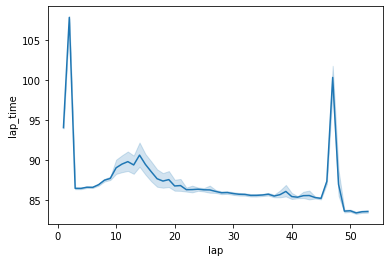

In [38]:
vettel = database.loc[(database['driver'] == 'VET')]
vettel = vettel.sort_values('lap')
pits = []
for index, row in vettel.iterrows():
    if 'pitinlap' in row['influence']:
        pits.append(row['lap'])
sns.lineplot(data=vettel, y='lap_time', x='lap')
#plt.ylim([85, 95])

In [ ]:
print(len(pits)/len(vettel['id'].unique()))
print(np.mean(pits))

<AxesSubplot:xlabel='lap', ylabel='lap_time'>

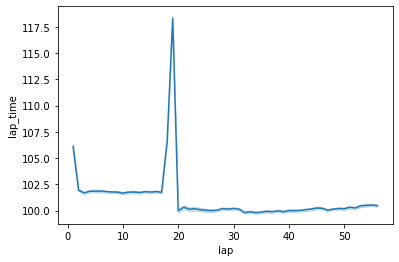

In [18]:
hamilton = database.loc[(database['driver'] == 'HAM')]
hamilton = hamilton.sort_values('lap')
pits = []
for index, row in hamilton.iterrows():
    if 'pitinlap' in row['influence']:
        pits.append(row['lap'])
sns.lineplot(data=hamilton, y='lap_time', x='lap')
#plt.ylim([85, 95])

In [20]:
len(pits)/len(hamilton['id'].unique())

1.0

In [21]:
vettel['cumulative_time'] = vettel['cumulative_time'].astype(int)
vettel[vettel['lap'] == vettel['lap'].max()].describe()

,lap,lap_time,cumulative_time,position
count,100.0,100.000000,100.00000,100.000000
mean,56.0,97.598990,5620.94000,1.510000
std,0.0,0.961654,7.48712,0.771919
min,56.0,96.096000,5606.00000,1.000000
25%,56.0,96.963000,5615.00000,1.000000
50%,56.0,97.354500,5620.00000,1.000000
75%,56.0,98.197250,5625.25000,2.000000
max,56.0,100.531000,5643.00000,4.000000


In [19]:
hamilton['position'] = hamilton['position'].astype(int)
hamilton['cumulative_time'] = hamilton['cumulative_time'].astype(int)
hamilton[hamilton['lap'] == hamilton['lap'].max()].describe()

,lap,lap_time,cumulative_time,position
count,100.0,100.00000,100.000000,100.000000
mean,71.0,73.40382,5299.150000,2.340000
std,0.0,0.62164,10.965856,1.327411
min,71.0,71.87600,5274.000000,1.000000
25%,71.0,73.01100,5291.000000,1.000000
50%,71.0,73.41350,5298.500000,2.000000
75%,71.0,73.78850,5306.000000,3.000000
max,71.0,75.26500,5324.000000,7.000000


In [10]:
ham = hamilton[hamilton['lap'] == hamilton['lap'].max()]
vet = vettel[vettel['lap'] == vettel['lap'].max()]
ham['id'] = ham['id'].astype(int)
vet['id'] = ham['id'].astype(int)
ham.sort_values('id')
vet.sort_values('id') 
delta = vet['cumulative_time'].values - ham['cumulative_time'].values

print("Delta {} +- {}".format(np.mean(delta), np.std(delta)))

Delta 14.95 +- 13.621582140118672


In [16]:
import numpy as np
import matplotlib.pyplot as plt
online_scores = np.load('../data/2020-10-14_18-21/game/trpo_2_32_0.001/models/2020-10-14_18-21/online_scores.npy')
offline_scores = np.load('../data/2020-10-14_18-21/game/trpo_2_32_0.001/models/2020-10-14_18-21/offline_scores.npy', allow_pickle=True)
print(offline_scores)

[list([7.89640374307387, 0.0]) 3.08 3.02 3.34 0.0
 list([12.57562964395507, 0.0]) 17.92 1.72 21.98 0.0
 list([12.998051882745498, 0.0]) 23.64 1.08 20.86 0.0
 list([13.195839795640815, 0.0]) 17.04 1.02 27.82 0.0
 list([13.216797443994983, 0.0]) 14.54 1.08 29.9 0.0]


<AxesSubplot:>

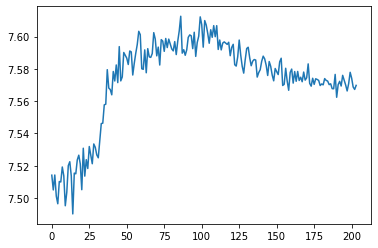

In [13]:
sns.lineplot(data=online_scores)

In [11]:
sns.lineplot(data=online_scores[:, 0])
plt.title("Return per epoch")

import numpy as np

lower_bound = online_scores[:, 0] - online_scores[:, 1]
upper_bound = online_scores[:, 0] + online_scores[:, 1]

plt.fill_between(np.arange(200) , lower_bound, upper_bound, alpha=.3)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed